**Scenario: Smart Email Responder**

Build an AI that routes emails intelligently based on content.

**Flow:**

LLM analyzes email intent (question/complaint/feedback/spam)
LLM determines urgency (high/medium/low)

**Conditional routing:**

- Spam → Auto-delete
- Complaint + High urgency → Apologetic response (LLM)
- Question + Technical → Detailed answer (LLM with RAG)
- Feedback → Thank you note (LLM)
- Low urgency → Queue for later


In [56]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Optional, Any, Literal
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from utils import AWSLLM

In [ ]:
# moddel for the classifier
class Classifier(BaseModel):
    intent: Literal['Question', 'Complaint', 'Feedback', 'Spam']
    urgency: Optional[Literal['High', 'Medium', 'Low']]

# model for question and detection    
class Technical_Detector(BaseModel):
    question: Optional[str] = Field(description="Extract the Question from the email.")
    is_technical: bool = Field(description="Classify the question is technical or not.")

In [ ]:
# define state for the workflow
class SmartEmailState(TypedDict):
    email_text: str
    intent: Optional[str]
    urgency: Optional[str]
    is_spam: bool
    is_technical: Optional[bool]
    question: Optional[str]
    retrieved_context: Optional[str]
    response: str

In [59]:
llm = AWSLLM()

In [ ]:
# classify the email basis on intent and urgency
def classifier(state: SmartEmailState):
    email = state["email_text"]
    
    response = llm.chat(email, Classifier)
    state['intent']= response.intent
    state['urgency'] = response.urgency
    
    return state

# a coditional function node to detect spam or not
def is_spam(state: SmartEmailState):
    intent = state["intent"]

    if intent == "Spam":
        return {'is_spam': True}
    else:
        return {'is_spam': False}

# delete the email is the email is spam
def delete(state: SmartEmailState):
    
    state["response"] = "This email was identified as spam and has been deleted."
    return state

def router(state: SmartEmailState):
    return state

def check_status(state: SmartEmailState):
    intent = state["intent"]
    urgency = state["urgency"]

    if intent == "Question":
        return "question"

    if intent == "Complaint" and urgency == "High":
        return "apology_response"

    if intent == "Complaint" and urgency != "High":
        return "queue"

    if intent == "Feedback":
        return "feedback"

# node function for retrive question from email and detect technical or not
def technical_detection(state: SmartEmailState):
    email = state["email_text"]

    response = llm.chat(email, Technical_Detector)
    state["question"] = response.question
    state["is_technical"] = response.is_technical

    return state

# conditional function for next node selection rag or simple llm
def check(state: SmartEmailState):
    is_tech = state["is_technical"]

    if is_tech == True:
        return True
    else:
        return False

# RAG response node function
def rag_answer(state: SmartEmailState):
    from RAG import KBRag

    user_question = state['question']   
    kbrag = KBRag(pdf_path="Recruitment_Portal_Knowledge_Base.pdf")
    rag_response = kbrag(user_question)
    
    state["response"] = rag_response
    return state

# if the question is not technical
def llm_response(state: SmartEmailState):
    intent = state["intent"]
    urgency = state["urgency"]
    email = state["email_text"]

    prompt = f"""You are a professional customer support assistant.
                Email:
                {email}
                Intent: {intent}
                Urgency: {urgency}
                Write a polite, helpful, and complete response.
                Keep the tone friendly and professional.
                """
    state["response"] = llm.chat(prompt)
    return state

# function for apology response
def apology_response(state: SmartEmailState):
    email = state["email_text"]
    prompt = f"""You are a customer support assistant handling a complaint.
                Email:
                {email}
                Write a sincere apology.
                Acknowledge the issue and reassure the user that it will be addressed.
                Keep it calm, empathetic, and professional.
                """
    state["response"] = llm.chat(prompt)
    return state

# feedback response function
def feedback_response(state: SmartEmailState):
    email = state["email_text"]
    prompt = f"""You are responding to customer feedback.
                Email:
                {email}
                Thank the user for their feedback.
                If positive, express appreciation.
                If negative, acknowledge and assure improvement.
                Keep the response short and respectful.
                """
    state["response"] = llm.chat(prompt)
    return state

# if the urgency is low the the email should be in queue
def queue(state: SmartEmailState):
    email = state["email_text"]
    
    prompt = f"""You are a support assistant.
                Email:
                {email}
                Inform the user that their request requires further review.
                Assure them it has been forwarded to the appropriate team.
                Do not provide a solution.
                Be polite and professional.
                """
    state["response"] = llm.chat(prompt)
    return state


In [ ]:
# Define Graph
graph = StateGraph(SmartEmailState)

graph.add_node('classifier', classifier)
graph.add_node('is_spam', is_spam)
graph.add_node('delete', delete)
graph.add_node('router', router)
graph.add_node('technical_detection', technical_detection)
graph.add_node('rag_answer', rag_answer)
graph.add_node('llm_response', llm_response)
graph.add_node('apology_response', apology_response)
graph.add_node('feedback_response', feedback_response)
graph.add_node('queue', queue)


In [ ]:
# Edges
graph.add_edge(START, 'classifier')
graph.add_edge('classifier', 'is_spam')

graph.add_conditional_edges(
    "is_spam",
    lambda state: state["is_spam"],
    {
        True: "delete",
        False: "router"
    }
)

# Conditional edges for different type
graph.add_conditional_edges(
    "router",
    check_status,
    {
        'question': 'technical_detection',
        'apology_response': 'apology_response',
        'feedback': 'feedback_response',
        'queue': 'queue'
    }
)

# conditional node 
graph.add_conditional_edges(
    'technical_detection',
    check,
    {
        True: 'rag_answer',
        False: 'llm_response'
    }
)
graph.add_edge('rag_answer', END)
graph.add_edge('llm_response', END)
graph.add_edge('apology_response', END)
graph.add_edge('feedback_response', END)
graph.add_edge('queue', END)


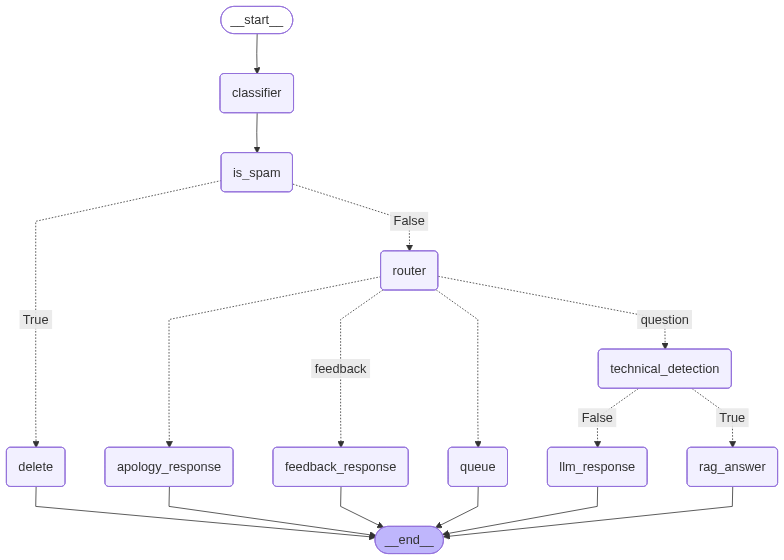

In [63]:
workflow = graph.compile()
workflow

In [64]:
email = """Subject: Interview link not working
Body:
Hello,
My virtual interview is scheduled in 30 minutes, but the meeting link is not opening at all. This is extremely urgent and I need immediate assistance.
"""
workflow.invoke({'email_text': email})

{'email_text': 'Subject: Interview link not working\nBody:\nHello,\nMy virtual interview is scheduled in 30 minutes, but the meeting link is not opening at all. This is extremely urgent and I need immediate assistance.\n',
 'intent': 'Complaint',
 'urgency': 'High',
 'is_spam': False,
 'response': "Subject: Re: Interview link not working\n\nDear [Customer's Name],\n\nI hope this message finds you well. I'm truly sorry to hear about the difficulties you're facing with the interview link. I understand how critical and stressful this situation must be, especially with your interview scheduled so soon.\n\nFirstly, please accept my sincerest apologies for any inconvenience this may have caused you. I want to assure you that we are fully aware of the issue and our technical team is working diligently to resolve it as quickly as possible.\n\nYour time is valuable, and we are committed to ensuring that this matter is addressed urgently. In the meantime, I would recommend trying to access the l

In [65]:
email = """Subject: Unable to upload my resume
Body:
Hi team,
I’m trying to upload my resume on the recruitment portal, but it keeps showing “File format not supported.” My file is a PDF and under 5 MB. Can you help me understand what’s going wrong?

"""
workflow.invoke({'email_text': email})

{'email_text': 'Subject: Unable to upload my resume\nBody:\nHi team,\nI’m trying to upload my resume on the recruitment portal, but it keeps showing “File format not supported.” My file is a PDF and under 5 MB. Can you help me understand what’s going wrong?\n\n',
 'intent': 'Question',
 'urgency': 'Medium',
 'is_spam': False,
 'is_technical': True,
 'question': 'I’m trying to upload my resume on the recruitment portal, but it keeps showing “File format not supported.” My file is a PDF and under 5 MB. Can you help me understand what’s going wrong?',
 'response': 'If the resume upload fails with a "File format not supported" message, despite your file being a PDF and under 5 MB, it may be due to the presence of special characters in the file name. Candidates should avoid using special characters in file names when uploading their resumes.\n\n"Information not available in the knowledge base."'}

In [66]:
email = """Subject: Application status inquiry
Body:
Hello,
Could you tell me how I can check the status of my job application? I’m not in a hurry — just want to know where to find it on the portal.


"""
workflow.invoke({'email_text': email})

{'email_text': 'Subject: Application status inquiry\nBody:\nHello,\nCould you tell me how I can check the status of my job application? I’m not in a hurry — just want to know where to find it on the portal.\n\n\n',
 'intent': 'Question',
 'urgency': 'Low',
 'is_spam': False,
 'is_technical': False,
 'question': 'Could you tell me how I can check the status of my job application? I’m not in a hurry — just want to know where to find it on the portal.',
 'response': 'Subject: Re: Application Status Inquiry\n\nDear [Applicant\'s Name],\n\nThank you for reaching out to us regarding your job application status. We appreciate your interest in our company and are pleased to assist you.\n\nTo check the status of your application, please follow these steps:\n\n1. **Log In to the Portal:**\n   - Visit our careers portal at [insert portal URL].\n   - Click on the “Login” button, usually located at the top right corner of the page.\n   - Enter your registered email address and password to access yo

In [67]:
email = """Subject: Earn money instantly!!!
Body:
Congratulations! You have won a free work‑from‑home job. Click the link below to claim your reward. Limited time offer.

"""
workflow.invoke({'email_text': email})

{'email_text': 'Subject: Earn money instantly!!!\nBody:\nCongratulations! You have won a free work‑from‑home job. Click the link below to claim your reward. Limited time offer.\n\n',
 'intent': 'Spam',
 'urgency': 'High',
 'is_spam': True,
 'response': 'This email was identified as spam and has been deleted.'}